#**Generative Machine Learning / Deep Learning:**

#**Generative Adversarial Networks**

**Generative Adversarial Networks** were introduced by the Guru of Deep Learning, Ian Goodfellow in 2014 and are a way to learn Latent Spaces of Images. 

**GAN** produced the plague of **Deep Fakes**

Basically, a **GAN** is made of a "Fake" Network (Generator) and an "Expert" Network (Discriminator) which are adversarially trained to overcome the other one reciprocally: 

1) **Generator**: takes a random vector in input (a random point in the latent space) and decode it into a synthetic image

2) **Discriminator** (or adversarial) : takes a real image or synthetic as input and classifies it as real or fake 

#**All General Imports**

In [ ]:
from os.path import exists
import matplotlib.pyplot as plt

#**All Tensorflow 2.x (Keras) Imports**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dropout, Dense, LeakyReLU, Reshape, Conv2DTranspose
from tensorflow.keras.utils import image_dataset_from_directory

#**All Globals**

In [ ]:
n_rows_to_plot = 4
n_cols_to_plot = 4
summary = True

#**All Hyper-parameters**

In [ ]:
latent_space_dim = 128
epochs = 100

#**All Datasets Downloads**

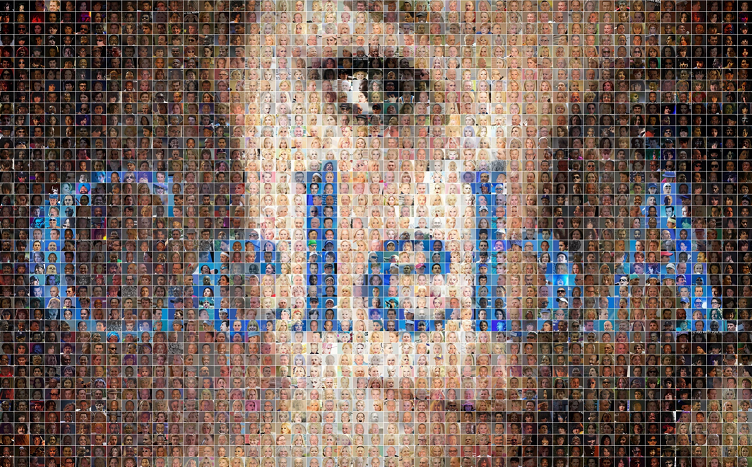

In [ ]:
if not exists("./celeba_gan"):
  !mkdir celeba_gan
  !gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
  !unzip -qq celeba_gan/data.zip -d celeba_gan

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:08<00:00, 178MB/s]


#**Data Preparation**

In [ ]:
dataset = image_dataset_from_directory("celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32, smart_resize=True)

Found 202599 files belonging to 1 classes.


#**Data Scaling (Normalization)**

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

#**Dataset Visualization Sanity Check**

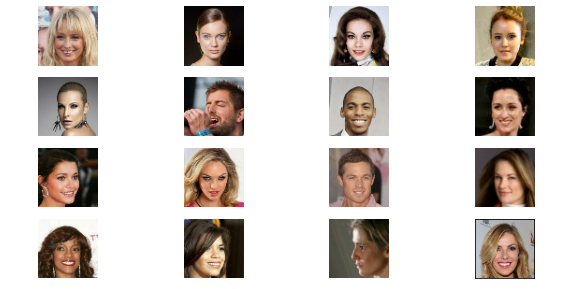

In [ ]:
fig = plt.figure(figsize=(10,5))
i = 0
for im in dataset: 
    plt.axis("off")
    ax = fig.add_subplot(n_rows_to_plot, n_cols_to_plot, 1 + i, xticks=[], yticks=[])
    plt.imshow((im.numpy() * 255).astype("int32")[0])
    i += 1
    if i >= n_rows_to_plot*n_cols_to_plot: 
      break
plt.show()

#**All Callbacks Definitions**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

#**All Classes Definitions**

A **GAN** network concatenate the generator and the discriminator so: 

*gan = discriminator(generator(x))*

So a **GAN** maps the points (vectors) from the latent space to the discriminator evaluations about the realism of these latent vectors encoded by the generator into images. 

**Discriminator** is trained on true and false image dataset samples, with opposite labels, such as every classification model 

**Generator** is trained adopting weights gradients of the generator with respect to the loss of the gan. We change weights of the Generator in the direction such as the discriminator is cheated and classfies "fake" images as "real". In other words, the generator is trained to mislead the discriminator. 

In [ ]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Discriminator Training Stage for Each Epoch
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Generator Training Stage for Each Epoch
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

#**All Models Definitions**

#**Discriminator Definition**

The **Discriminator** takes a real or synthetic image as input and classifies it as real or fake, so it is a binary classifier

Two things can foster the gradients sparsity: max-pooling and Relu. So we use Convolutions for Downsampling and Transposed Convolutions for the Upsampling, no max-pooling or up-sampling at all. We use **LeakyRelus**, which means Relu with a small slope for negatives, and so there are less sparsity constraints. 

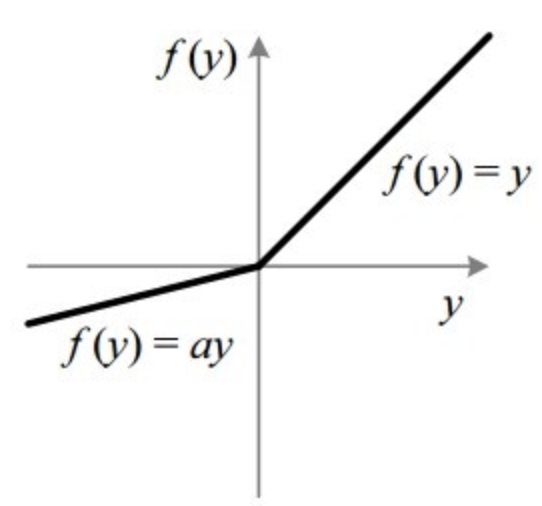

In [ ]:
discriminator = Sequential(name="Discriminator")
discriminator.add(Input(shape=(64, 64, 3)))
discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.2))
discriminator.add(Dense(1, activation="sigmoid"))
if summary: 
  discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

#**Generator Definition**

The **Generator** transforms a Latent Space vector into an candidate image. Sometimes the generator can be stuck on image which seem "noise". A solution is to adopt dropout for the generator and the discriminator. 

In [ ]:
generator = Sequential(name="Generator")
generator.add(Input(shape=(latent_space_dim,)))
generator.add(Dense(8 * 8 * 128))
generator.add(Reshape((8, 8, 128)))
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"))
if summary: 
  generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 256)       0 

**GAN Algorithm: for every epoch**

1) Extract random points from the Latent Space

2) Generate images for the Generator adopting random noise (Gaussian Noise better)

3) Mix true images with generated ones

4) Train the discriminator by these mixed images, with the labels: true for real images, and false for generated images

5) Extract new points from the latent space

6) Train the GAN adopting these random vectors, with all labels saying "true". This update Generators weights (only generator, discriminator is freezed) to check if the discrimator is able to recognize them or it says they are all "true" also the generated ones. This trains the generator to mislead the discriminator. 

**NOTE!** During the GAN training, discriminator must be freezed (it's already trained), its weight wont be updated. If discriminator weights were updated we would end up to train the discriminator to predict always "true" which is what we don't want. 

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_space_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_space_dim)]
)

Epoch 1/100
6332/6332 [==============================] - 1993s 312ms/step - d_loss: 0.6126 - g_loss: 1.1775
Epoch 2/100
6332/6332 [==============================] - 1980s 313ms/step - d_loss: 0.6688 - g_loss: 1.0395
Epoch 3/100
6332/6332 [==============================] - 1976s 312ms/step - d_loss: 0.6768 - g_loss: 0.9735
Epoch 4/100
6332/6332 [==============================] - 1974s 312ms/step - d_loss: 0.6747 - g_loss: 0.9758
Epoch 5/100
  84/6332 [..............................] - ETA: 32:24 - d_loss: 0.6916 - g_loss: 0.8523

KeyboardInterrupt: ignored